In [81]:
#Solar Astrophysics Tarea 1 punto 2 Juan Pablo Herrera
import numpy as np 
import matplotlib.pyplot as plt 
import numpy as np
from astropy.io import fits

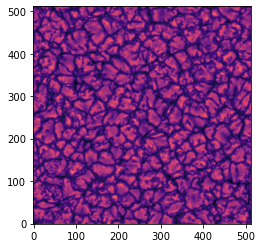

In [82]:
# Imagen solar
image = fits.open("synth_sun.fits")[0].data
plt.imshow(image,origin='lower',cmap='magma')


In [83]:
image2=image[:64,:64] #Imagen de 64x64 para que sea de la misma dimesion de la PSF

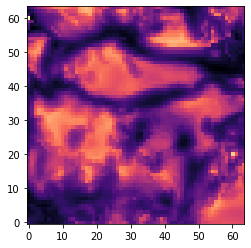

In [84]:
plt.imshow(image2,origin='lower',cmap='magma')

In [85]:
#Conovolución como la vista en hands-on

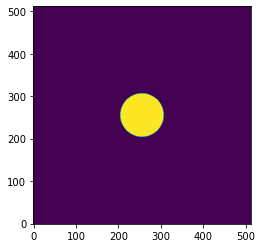

In [86]:
#make the aperture
N = 512 #number of points 
a = 1.0 #total size of the grid, in meters
aperture = np.zeros([N,N]) #array containing the aperture (1 will be where light can enter, zero where it cannot)

x = np.linspace(-a/2.0,a/2.0,N) #x grid
y = np.linspace(-a/2.0,a/2.0,N) #y grid
R = 0.1 #radius of our telescope, this is one m, like SST :) 

#make circular aperture
for i in range(0,N):
    for j in range(0,N):
        if ((x[i]**2.0 + y[j]**2.0)**0.5 <= R):
            aperture[i,j] = 1.0

plt.imshow(np.real(aperture),origin='lower') #plot the aprerture

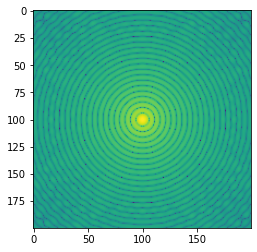

In [87]:
# Now, from the (complex) aperture, we calculate the FFT:
aperture_fft = np.fft.fft2(aperture)
PSF = np.abs(aperture_fft)
PSF = PSF**2.0

# we need to rearange this:
PSF = np.fft.fftshift(PSF,axes=(0,1))

#we are only going to be interested in the innermost part of the PSF
N_small = 200
PSF = PSF[N//2-N_small//2:N//2+N_small//2,N//2-N_small//2:N//2+N_small//2]
# we plot psf in the log scale
plt.imshow(np.log10(PSF[:,:]))

(0.0, 0.05)

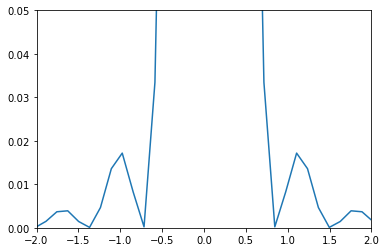

In [88]:

x_step = a / N #step of the original image
xf = np.linspace(-1.0/(2.0*x_step),1.0/(2.0*x_step), N) #space of spatial frequencies
llambda = 630E-9 # wavelength we are observing at
theta = xf*llambda * 206265 #transform the spatial frequencies to angles
theta = theta[N//2-N_small//2:N//2+N_small//2] #select the appropriate part for the narrowed down PSF
norm = np.amax(PSF) # we want to normalize the psf with respect to maximum first: 
PSF /= norm
plt.plot(theta,PSF[100]) #plot the middle raw
plt.xlim([-2,2])
plt.ylim([0,0.05])

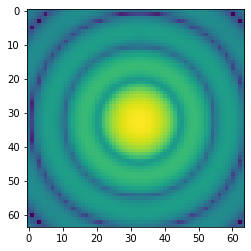

In [89]:
#interpolación
scale = 48.0/725.0 #in arcsec
grid_interpolate = np.linspace(-31.5,31.5,64)*scale

from scipy import interpolate
f = interpolate.interp2d(theta,theta,PSF)
psf_interpolated = f(grid_interpolate,grid_interpolate)
plt.imshow(np.log10(psf_interpolated))

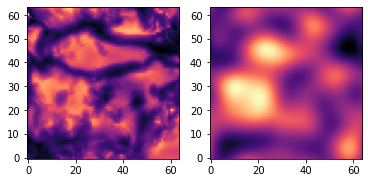

In [90]:
# now finally, convolve (Para este punto, la conovolución se realizó en el espacio de Fourier)
from scipy.signal import convolve2d

# we have to normalize again so that the surface of the psf is one 
psf_interpolated /= np.sum(psf_interpolated)

#image_smeared = convolve2d(image2,psf_interpolated,mode='same',boundary='symm') 
A=np.fft.fft2(image2)
B=np.fft.fft2(psf_interpolated)
mean = np.mean(psf_interpolated)
image2 /= mean
image_smeared /=mean
C=np.multiply(A,B)
image_smeared=np.fft.fftshift(np.fft.ifft2(C).real)
##convolution messes up with our edges, so we can get rid of them:
#image = image[50:-50,50:-50]
#image_smeared = image_smeared[32:-32,32:-32]

plt.subplot(121)
plt.imshow(image2,origin='lower',cmap='magma')
plt.subplot(122)
plt.imshow(image_smeared,origin='lower',cmap='magma')

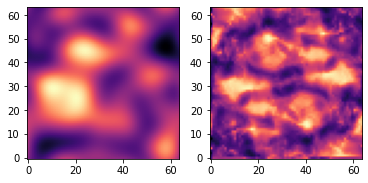

In [91]:
#Se realiza la deconovolución en el espaciode Fourier y con transformada inversa
s=image_smeared
p=psf_interpolated
S=np.fft.fft2(s)
P=np.fft.fft2(p)
IMAGER=S//P
#plt.imshow(s,vmin=0.7,vmax=1.3,origin='lower',cmap='magma')
i=np.fft.fftshift(np.fft.ifft2(IMAGER).real)
plt.imshow(i,origin='lower',cmap='magma')
plt.subplot(121)
plt.imshow(image_smeared,origin='lower',cmap='magma')
plt.subplot(122)
plt.imshow(i,origin='lower',cmap='magma')

In [92]:
#Para la deconovolución (al menos por Fourier) es necesario que la imagen solar y la PSF que se va a deconovlucionar 
#tengan las mismas dimensiones, y fue necesario hacer el proceso de conolovución por Fourier en lugar de la funcion convolve2d.
#Y fue posible ya que se conocía de antemano la PSF.